In [1]:
'''
Load the data and plot the means for each of the digit classes in the training data
(include these in your report). Given that each image is a vector of size 64, the mean will
be a vector of size 64 which needs to be reshaped as an 8 × 8 2D array to be rendered as an
image. Plot all 10 means side by side using the same scale
'''

import data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

The shape of each digit-image from 0-9 is:  [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]


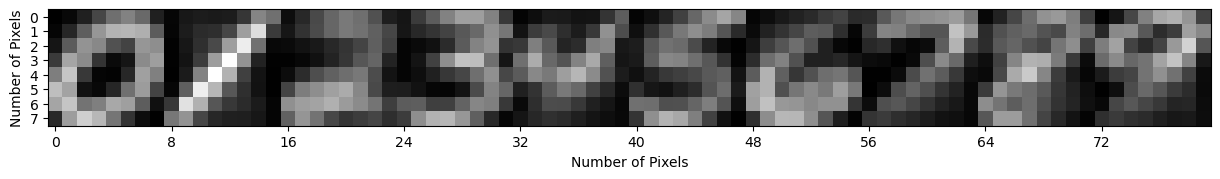

In [2]:
def plot_means(train_data, train_labels):
    means = []
    for i in range(0, 10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)
        # Compute mean of class i
        digits_mean = np.mean(i_digits, axis=0)
        means.append(digits_mean.reshape((8,8)))


    # Plot all means on same axis
    print("The shape of each digit-image from 0-9 is: ",[digit.shape for digit in means])
    all_concat = np.concatenate(means, 1)
    plt.figure(figsize=(15, 120))
    plt.imshow(all_concat, cmap='gray')
    plt.xticks([i for i in range (80) if i%8 == 0])
    plt.yticks([i for i in range (8)])
    plt.xlabel("Number of Pixels")
    plt.ylabel("Number of Pixels")
    plt.show()

if __name__ == '__main__':
    train_data, train_labels, _, _ = data.load_all_data_from_zip('a3digits.zip', 'data')
    plot_means(train_data, train_labels)

In [3]:
'''
KNN Classifier
'''

class KNearestNeighbor(object):
    '''
    K Nearest Neighbor classifier
    '''

    def __init__(self, train_data, train_labels):
        self.train_data = train_data
        self.train_norm = (self.train_data**2).sum(axis=1).reshape(-1,1)
        self.train_labels = train_labels

    def l2_distance(self, test_point):
        '''
        Compute L2 distance between test point and each training point
        
        Input: test_point is a 1d numpy array
        Output: dist is a numpy array containing the distances between the test point and each training point
        '''
        # Process test point shape
        test_point = np.squeeze(test_point)
        if test_point.ndim == 1:
            test_point = test_point.reshape(1, -1)
        assert test_point.shape[1] == self.train_data.shape[1]

        # Compute squared distance
        test_norm = (test_point**2).sum(axis=1).reshape(1,-1)
        dist = self.train_norm + test_norm - 2*self.train_data.dot(test_point.transpose())
        return np.squeeze(dist)

    def query_knn(self, test_point, k):
        '''
        Query a single test point using the k-NN algorithm

        You should return the digit label provided by the algorithm
        '''
        l2_dists = self.l2_distance(test_point) #Compute distances between the test point and each training point
        k_min_dists = l2_dists.argsort()[:k]    #Get first k least distances
        #print(k_min_dists)
        #print(self.train_labels[k_min_dists])
        digit = np.argmax(np.bincount(self.train_labels[k_min_dists].astype(int))) #Get the label with highest frequency/occurences
        digit = digit.astype(float)
        return digit
    
    def predict(self, k, eval_data):
        eval_pred = np.zeros(eval_data.shape[0])
        for i in range(eval_data.shape[0]):
            eval_pred[i] = self.query_knn(eval_data[i], k)

        return eval_pred

def cross_validation(train_data, train_labels, k_range=np.arange(1,16)):
    '''
    Perform 10-fold cross validation to find the best value for k

    Note: Previously this function took knn as an argument instead of train_data,train_labels.
    The intention was for students to take the training data from the knn object - this should be clearer
    from the new function signature.
    '''
    folds = 10
    Highest_accuracy = 0.0
    Optimal_k = 0
    avg_acc_fold = []
    
    for k in k_range:
        kf = KFold(n_splits=folds)
        i = 1
        acc_k = []
        
        #Splitting the data into train and validations sets
        for train_index, validation_index in kf.split(train_data):
            train_data_fold = train_data[train_index]
            train_label_fold = train_labels[train_index]
            validation_data_fold =  train_data[validation_index]
            validation_label_fold = train_labels[validation_index]
            
            #KNN Model for a fold
            knn_fold = KNearestNeighbor(train_data_fold, train_label_fold)
            accuracy_fold = classification_accuracy(knn_fold, k, validation_data_fold, validation_label_fold)
            print('For k = {}, and fold no.: {}, accuracy is: {}'.format(k,i,accuracy_fold))
            acc_k.append(accuracy_fold)
            i += 1
 
        #Calaculating the average accuracy across folds for each k
        avg_accuracy_folds = np.mean(acc_k)
        avg_acc_fold.append(avg_accuracy_folds)
        print("For k = {}, the average accuracy accross folds = {}".format(k,avg_accuracy_folds))
        print("\n")
        
        #Getting the optimal k with highest average accuracy across folds
        if(avg_accuracy_folds > Highest_accuracy):
            Highest_accuracy = avg_accuracy_folds
            Optimal_k = k
            
    #Visualization Plot the classification accuarcy for each k
    #k_value = k_range
    #plt.title('Classification Accuracy vs. K')
    #plt.plot(k_value, avg_acc_fold, marker='o')
    #plt.xlabel('Number of Neighbors')
    #plt.ylabel('Classification Accuracy')
    #plt.xticks(k_value)
    #plt.show()
    
    #Summarizing the results
    for i in range (len(k_range)):
        print("For k = {}, the average accuracy accross folds = {}".format(k_range[i], avg_acc_fold[i]))
        
    return Highest_accuracy, Optimal_k

In [4]:
def classification_accuracy(knn, k, eval_data, eval_labels):
    '''
    Evaluate the classification accuracy of knn on the given 'eval_data'
    using the labels
    '''
   
    eval_pred = knn.predict(k, eval_data)
    count = []
    for i in range (len(eval_pred)):
        if eval_labels[i] == eval_pred[i]:
            count.append(1)
        else:
            count.append(0)
    accuracy = np.mean(count)*100
    return accuracy

In [5]:
def main():
    train_data, train_labels, test_data, test_labels = data.load_all_data('data', shuffle=True)
    knn = KNearestNeighbor(train_data, train_labels)
    
    #Computing train and test classification accurarices for K=1
    print("\n")
    classify_accuracy_train_k1 = classification_accuracy(knn, 1, train_data, train_labels)
    classify_accuracy_test_k1 = classification_accuracy(knn, 1, test_data, test_labels)
    print("For K = 1, the classification accuracy of the training set is: ", classify_accuracy_train_k1)
    print("For K = 1, the classification accuracy of the test set is: ", classify_accuracy_test_k1)
    print("\n")
     
    #Computing train and test classification accurarices for K=15
    classify_accuracy_train_k15 = classification_accuracy(knn, 15, train_data, train_labels)
    classify_accuracy_test_k15 = classification_accuracy(knn, 15, test_data, test_labels)
    print("For K = 15, the classification accuracy of the training set is: ", classify_accuracy_train_k15)
    print("For K = 15, the classification accuracy of the test set is: ", classify_accuracy_test_k15)
    print("\n")
    
    # Example
    j = 1
    predicted_label = knn.query_knn(test_data[j], 4)
    print("An example test label: {}, the predicted label is: {}".format(test_labels[j],predicted_label))
    print("\n")
    
    #Q3.1.3 Selecting the optimal k and printing all accuracies
    avg_acc_folds, optimal_k = cross_validation(train_data, train_labels)
    train_accuracy = classification_accuracy(knn, optimal_k, train_data, train_labels) #Train accuracy for the optimal K
    test_accuracy = classification_accuracy(knn, optimal_k, test_data, test_labels)    #Test accuracy for the optimal K
    print("\nThe optimal k is K= {}, with train accuracy = {}, average accuracy across folds = {}, and  the test accuracy = {}".format(optimal_k, train_accuracy,avg_acc_folds, test_accuracy))

    
if __name__ == '__main__':
    main()



For K = 1, the classification accuracy of the training set is:  100.0
For K = 1, the classification accuracy of the test set is:  96.875


For K = 15, the classification accuracy of the training set is:  95.94285714285714
For K = 15, the classification accuracy of the test set is:  95.85000000000001


An example test label: 7.0, the predicted label is: 7.0


For k = 1, and fold no.: 1, accuracy is: 97.28571428571429
For k = 1, and fold no.: 2, accuracy is: 96.42857142857143
For k = 1, and fold no.: 3, accuracy is: 96.71428571428572
For k = 1, and fold no.: 4, accuracy is: 96.85714285714285
For k = 1, and fold no.: 5, accuracy is: 95.14285714285714
For k = 1, and fold no.: 6, accuracy is: 96.71428571428572
For k = 1, and fold no.: 7, accuracy is: 96.71428571428572
For k = 1, and fold no.: 8, accuracy is: 95.42857142857143
For k = 1, and fold no.: 9, accuracy is: 95.42857142857143
For k = 1, and fold no.: 10, accuracy is: 96.85714285714285
For k = 1, the average accuracy accross folds 

For k = 13, and fold no.: 4, accuracy is: 94.57142857142857
For k = 13, and fold no.: 5, accuracy is: 94.85714285714286
For k = 13, and fold no.: 6, accuracy is: 95.57142857142857
For k = 13, and fold no.: 7, accuracy is: 96.28571428571429
For k = 13, and fold no.: 8, accuracy is: 93.57142857142857
For k = 13, and fold no.: 9, accuracy is: 95.14285714285714
For k = 13, and fold no.: 10, accuracy is: 95.14285714285714
For k = 13, the average accuracy accross folds = 95.1


For k = 14, and fold no.: 1, accuracy is: 95.85714285714285
For k = 14, and fold no.: 2, accuracy is: 95.0
For k = 14, and fold no.: 3, accuracy is: 94.14285714285714
For k = 14, and fold no.: 4, accuracy is: 94.57142857142857
For k = 14, and fold no.: 5, accuracy is: 94.28571428571428
For k = 14, and fold no.: 6, accuracy is: 94.85714285714286
For k = 14, and fold no.: 7, accuracy is: 96.0
For k = 14, and fold no.: 8, accuracy is: 93.57142857142857
For k = 14, and fold no.: 9, accuracy is: 95.28571428571428
For k = 1

In [24]:
#Convert the labels into one hot encoding vectors
def one_hot_encode(vector):
    vector_reshaped = np.reshape(vector, (-1,1))
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encode_vector = one_hot_encoder.fit_transform(vector_reshaped)
    
    return one_hot_encode_vector

#Import the data and form the one hot encodings for all labels
def import_data():
    train_data, train_labels, test_data, test_labels = data.load_all_data('data', shuffle=True)
    train_labels_ohe = one_hot_encode(train_labels)
    test_labels_ohe = one_hot_encode(test_labels)
    
    return train_data, train_labels, train_labels_ohe, test_data, test_labels, test_labels_ohe

#Training the classifier and providing the validation accuracy to decide the best classifier
def clf_training(clf, train_data, train_labels):    
    #Spliting the training data into training and validation sets
    X_train, X_validation, Y_train, Y_validation = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_validation)
    accuracy = accuracy_score(Y_validation, Y_pred)*100
    return accuracy


In [25]:
#Compute Mean-Squared Error, Accuracy Score, Precision, Recall (both from Classfication Report) and Confusion Matrix
def classification_performance(Y_labels, Y_pred):
    
    mse = mean_squared_error(Y_labels, Y_pred)
    print("Mean Squared Error: ", mse)
    
    accuracy = accuracy_score(Y_labels, Y_pred)*100
    print("Accuracy Score: ", accuracy)
    
    classify_report = classification_report(Y_labels, Y_pred, zero_division=1)
    print("Classification Report: ")
    print(classify_report)
    
    conf_matrix = confusion_matrix(Y_labels, Y_pred)
    print("Confusion Matrix: ")
    print(conf_matrix )
    
#A function to compute the ROC metrics    
def ROC_curve_function(test_labels_ohe, clf_pred_ohe, n_classes=10):
    
    fpr_clf = dict()  #False Positives
    tpr_clf = dict()  #True Positives
    roc_auc_clf = dict() #Area under curve 
    
    for i in range(n_classes):
        fpr_clf[i], tpr_clf[i], _ = roc_curve(test_labels_ohe[:, i], clf_pred_ohe[:, i]) #Compute False Positive and True Negative metrics for ROC
        roc_auc_clf[i] = auc(fpr_clf[i], tpr_clf[i])  #Get area under curve
        
    return fpr_clf, tpr_clf, roc_auc_clf

In [26]:
#MLP Classifier
def MLP_clf(train_data, train_labels_ohe):

    Best_MLP = None
    Highest_MLP_accuracy = 0.0    
    l2_penalty = [0.001, 0.005, 0.01, 0.05]
    hidden_layers=[(16,8,4),(32,16,8),(64, 32, 16)]
    print("\n")
    
    for hl in hidden_layers:
        for l2 in l2_penalty:
        
            MLP_clf = MLPClassifier(solver='adam', alpha=l2,activation='relu',
                        hidden_layer_sizes=hl, random_state=42, max_iter=1000)
            with ignore_warnings(category=ConvergenceWarning):
                MLP_clf_accuracy = clf_training(MLP_clf, train_data, train_labels_ohe)  
            print("For MLP with hidden layer sequence as {} and l2_penalty as {}, we get (validation) accuracy = {}".format(hl, l2, MLP_clf_accuracy))
 
            if(MLP_clf_accuracy > Highest_MLP_accuracy):
                Best_MLP = MLP_clf
                Highest_MLP_accuracy = MLP_clf_accuracy
                
    Best_MLP.fit(train_data, train_labels_ohe)
    hidden_layer_sizes_best = Best_MLP.get_params()['hidden_layer_sizes']
    l2_best = Best_MLP.get_params()['alpha']
    print("The best MLP is obtained with {} as the hidden layer sequence and l2_penalty as {} and (validation) accuracy {}".format(hidden_layer_sizes_best,l2_best, Highest_MLP_accuracy))
    print("\n")
    return Best_MLP

In [27]:
#SVM Classifier
def SVM_clf(train_data, train_labels):

    Best_SVC = None
    Highest_SVC_accuracy = 0.0
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    print("\n")
    for kernel in kernels:

        SVC_clf = SVC(kernel=kernel)

        SVC_clf_accuracy = clf_training(SVC_clf, train_data, train_labels)
        print("For SVC with kernel as {}, we get accuracy (validation) = {}".format(kernel, SVC_clf_accuracy))

        if(SVC_clf_accuracy > Highest_SVC_accuracy):
            Best_SVC = SVC_clf
            Highest_SVC_accuracy = SVC_clf_accuracy
        
    best_kernel = Best_SVC.get_params()['kernel']
    Best_SVC.fit(train_data, train_labels)
    print("The best SVC is obtained with {} as kernel and (validation) accuracy {}".format(best_kernel, Highest_SVC_accuracy))
    print("\n")
    return Best_SVC

In [28]:
#Adaboost Classifier
def AdaBoost_clf(train_data, train_labels):
    
    Best_AdaBoost = None
    Highest_AdaBoost_accuracy = 0.0
    Best_depth = 0.0
    n_estimators = np.arange(1, 11)*100
    max_depths = [1,2,3]
    print("\n")
    
    for depth in max_depths:
        for n_estimator in n_estimators:

            #In this case, the weak learner is assumed to be a Decision Tree with max_depth = 1, 2, 3
            weak_learner = DecisionTreeClassifier(max_depth=depth)
            AdaBoost_clf = AdaBoostClassifier(weak_learner, n_estimators= n_estimator, random_state = 42)        

            AdaBoost_clf_accuracy = clf_training(AdaBoost_clf, train_data, train_labels)
            print("For AdaBoost with no. of estimators as {}, and weak-DT depth as {}, we get (validation) accuracy = {}".format(n_estimator, depth, AdaBoost_clf_accuracy))

            if(AdaBoost_clf_accuracy > Highest_AdaBoost_accuracy):
                Best_AdaBoost = AdaBoost_clf
                Highest_AdaBoost_accuracy = AdaBoost_clf_accuracy
                Best_depth = depth
                   
    Best_estimates = Best_AdaBoost.get_params()['n_estimators']
    Best_AdaBoost.fit(train_data, train_labels)
    print("The best AdaBoost is obtained with {} as number of estimators, {} as depth of weak-DT and (validation) accuracy {}".format(Best_estimates, Best_depth, Highest_AdaBoost_accuracy))
    return Best_AdaBoost

/Users/pranavkhanolkar/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/pranavkhanolkar/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


For K-Nearest Neighbor (KNN) classifier model
The optimal value of k was K = 1


For Multi-Layer Perceptron (MLP) classifier model


For MLP with hidden layer sequence as (16, 8, 4) and l2_penalty as 0.001, we get (validation) accuracy = 11.857142857142858
For MLP with hidden layer sequence as (16, 8, 4) and l2_penalty as 0.005, we get (validation) accuracy = 80.28571428571428
For MLP with hidden layer sequence as (16, 8, 4) and l2_penalty as 0.01, we get (validation) accuracy = 68.85714285714286
For MLP with hidden layer sequence as (16, 8, 4) and l2_penalty as 0.05, we get (validation) accuracy = 77.5
For MLP with hidden layer sequence as (32, 16, 8) and l2_penalty as 0.001, we get (validation) accuracy = 93.5
For MLP with hidden layer sequence as (32, 16, 8) and l2_penalty as 0.005, we get (validation) accuracy = 93.78571428571428
For MLP with hidden layer sequence as (32, 16, 8) and l2_penalty as 0.01, we get (validation) accuracy = 93.42857142857143
For MLP with hidden layer seque

/Users/pranavkhanolkar/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/pranavkhanolkar/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/pranavkhanolkar/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


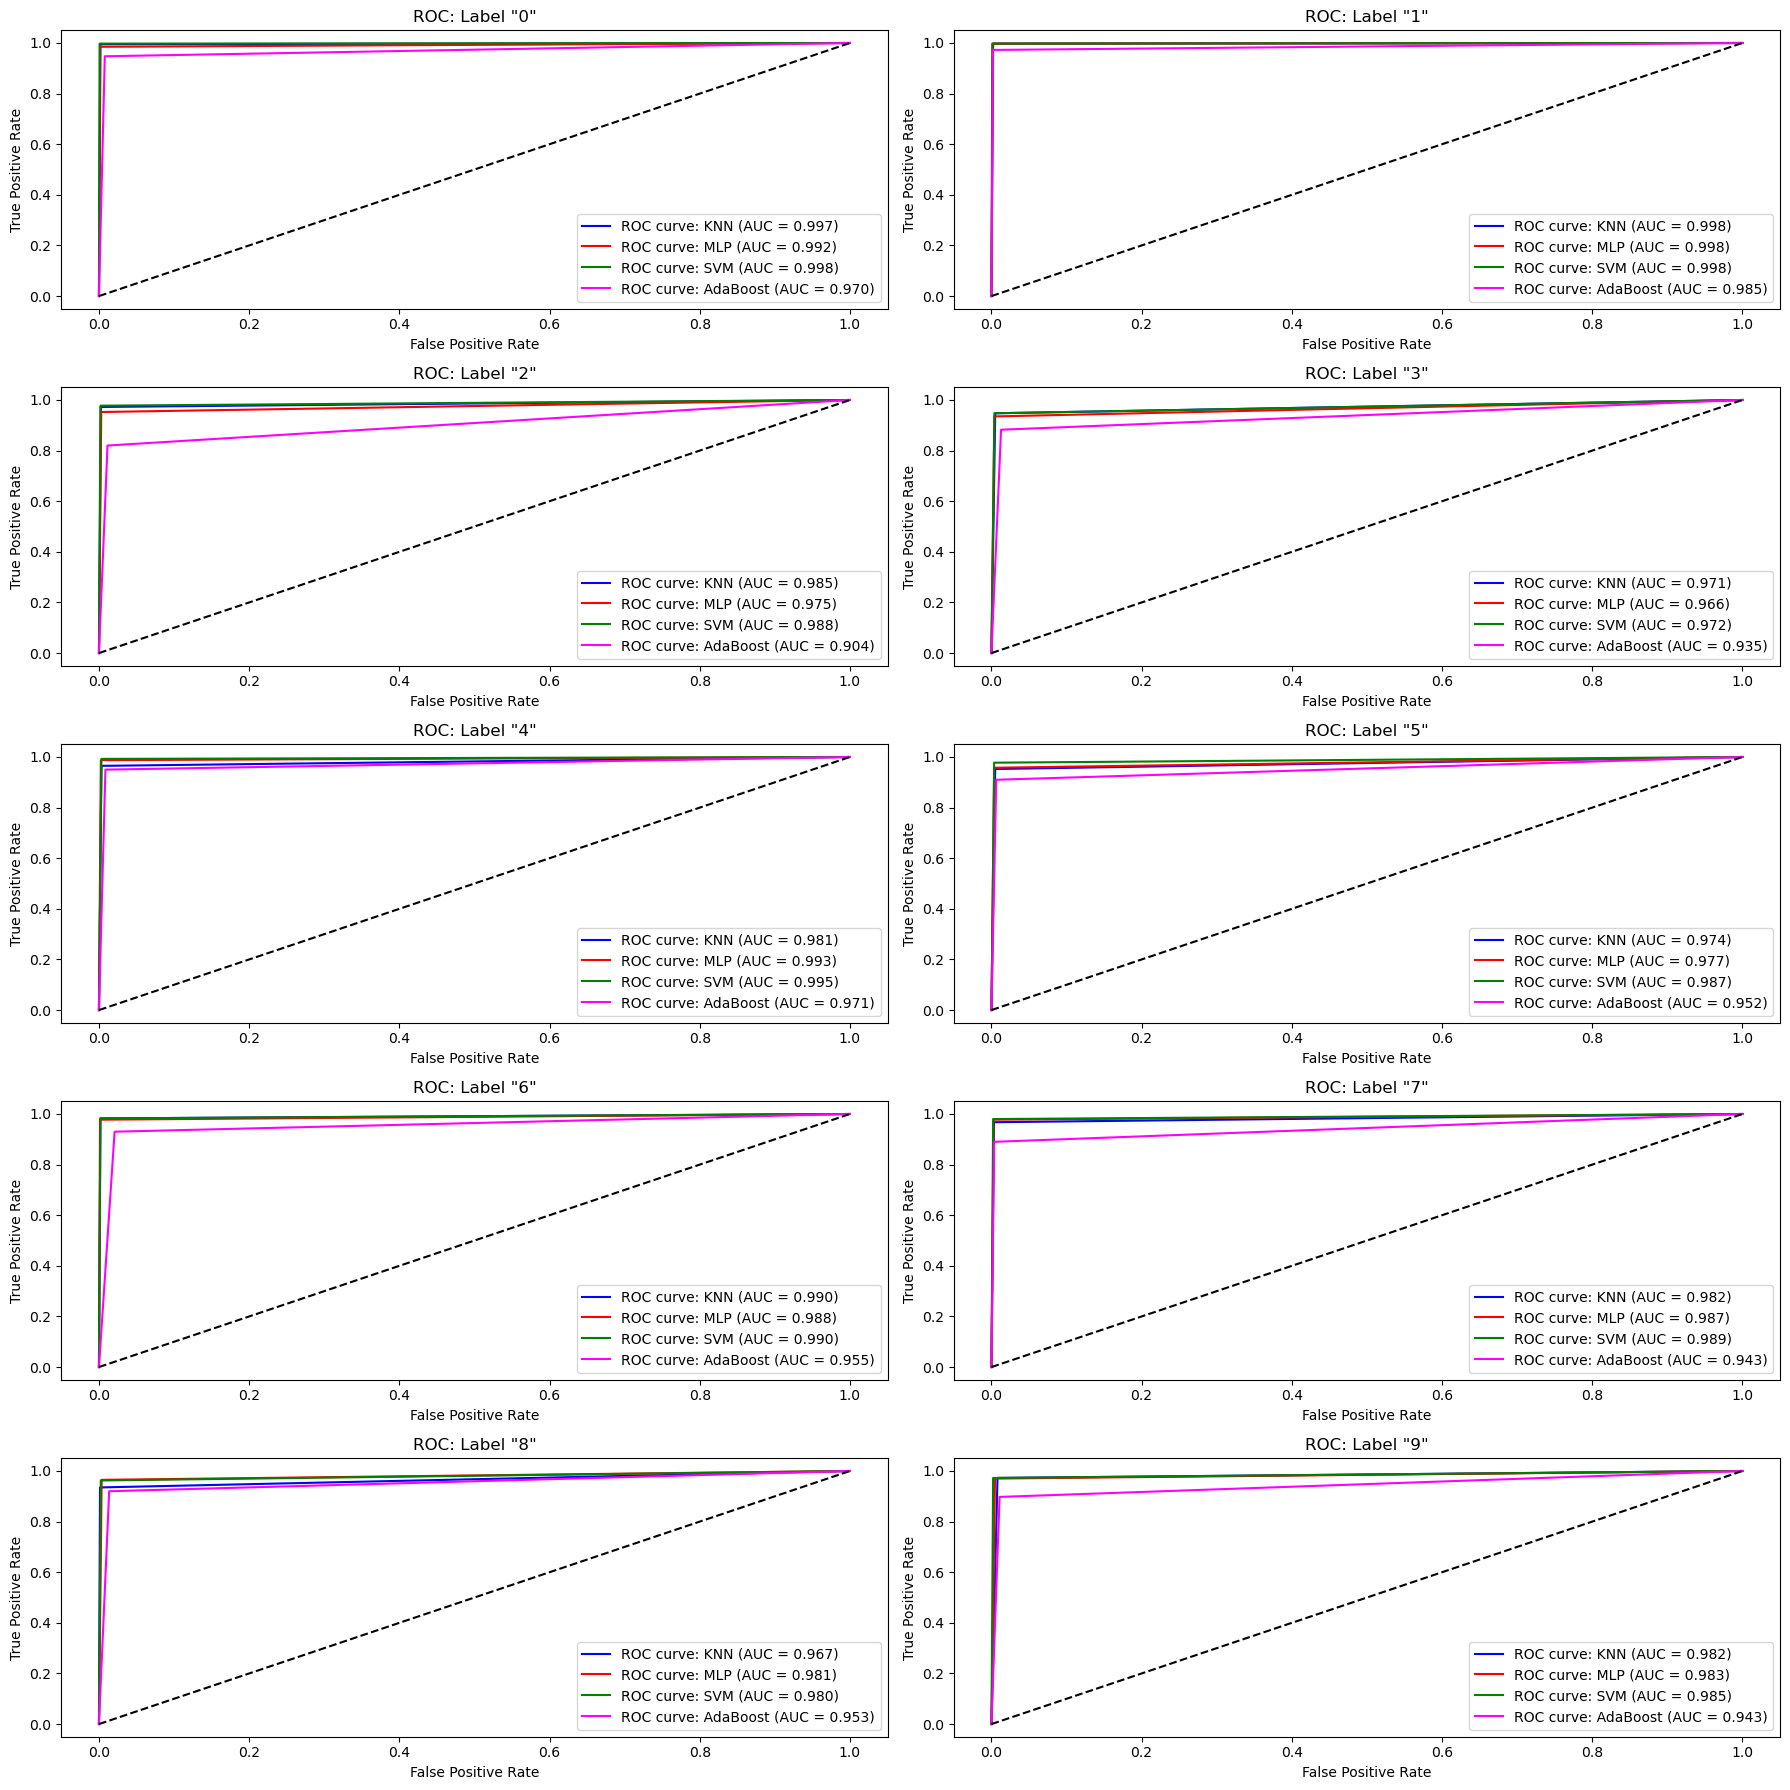

In [29]:
#Main function
def main():
    
    #Importing the Data
    train_data, train_labels, train_labels_ohe, test_data, test_labels, test_labels_ohe = import_data()
    
    #KNN model
    print("For K-Nearest Neighbor (KNN) classifier model")
    print("The optimal value of k was K = 1")
    k = 1 
    KNN = KNearestNeighbor(train_data, train_labels)
    KNN_pred = KNN.predict(k, test_data)
    
    #MLP model
    print("\n")
    print("For Multi-Layer Perceptron (MLP) classifier model")
    MLP_classifier = MLP_clf(train_data, train_labels_ohe)
    MLP_pred_ohe = MLP_classifier.predict(test_data)
    MLP_pred = MLP_pred_ohe.argmax(axis=1)

    #SVM model
    print("\n")
    print("For Support Vector Machine (SVM) classifier model")
    SVM_classifier = SVM_clf(train_data, train_labels)
    SVM_pred = SVM_classifier.predict(test_data)
    
    #AdaBoost model
    print("\n")
    print("For AdaBoost classifier model")
    AdaBoost_classifier = AdaBoost_clf(train_data, train_labels)
    AdaBoost_pred = AdaBoost_classifier.predict(test_data)
    
    #For Q3.3
    print("\n")
    print("The classification performance of the KNN model is provided as follows:")
    classification_performance(test_labels, KNN_pred)
    KNN_pred_ohe = one_hot_encode(KNN_pred) #Encoding KNN predictions for ROC plots
    KNN_fpr, KNN_tpr, KNN_roc_auc = ROC_curve_function(test_labels_ohe, KNN_pred_ohe)
    
    print("\n")
    print("The classification performance of the MLP model is provided as follows:")
    classification_performance(test_labels, MLP_pred)
    MLP_fpr, MLP_tpr, MLP_roc_auc = ROC_curve_function(test_labels_ohe, MLP_pred_ohe)
    
    print("\n")
    print("The classification performance of the SVM model is provided as follows:")
    classification_performance(test_labels, SVM_pred)
    SVM_pred_ohe = one_hot_encode(SVM_pred)    #Encoding SVM predictions for ROC plots
    SVM_fpr, SVM_tpr, SVM_roc_auc = ROC_curve_function(test_labels_ohe, SVM_pred_ohe)
    
    print("\n")
    print("The classification performance of the AdaBoost model is provided as follows:")
    classification_performance(test_labels, AdaBoost_pred)
    AdaBoost_pred_ohe = one_hot_encode(AdaBoost_pred)   #Encoding AdaBoost predictions for ROC plots
    AdaBoost_fpr, AdaBoost_tpr, AdaBoost_roc_auc = ROC_curve_function(test_labels_ohe, AdaBoost_pred_ohe)
    
    #ROC plots
    print("\n")
    print("The Receiver operating characteristic for the classifier models are provided in the following plots:")
    plt.figure(figsize=(18, 18))
    n_classes = 10
    for i in range(0, n_classes):
        ROC = plt.subplot(5, 2, i + 1)
        ROC.plot(KNN_fpr[i], KNN_tpr[i], label='ROC curve: KNN (AUC = %0.3f)' % KNN_roc_auc[i], color='blue')
        ROC.plot(MLP_fpr[i], MLP_tpr[i], label='ROC curve: MLP (AUC = %0.3f)' % MLP_roc_auc[i], color='red')
        ROC.plot(SVM_fpr[i], SVM_tpr[i], label='ROC curve: SVM (AUC = %0.3f)' % SVM_roc_auc[i], color='green')
        ROC.plot(AdaBoost_fpr[i], AdaBoost_tpr[i], label='ROC curve: AdaBoost (AUC = %0.3f)' % AdaBoost_roc_auc[i], color='magenta')
        ROC.plot([0, 1], [0, 1], 'k--')
        ROC.legend(loc="lower right")
        ROC.set_xlabel('False Positive Rate')
        ROC.set_ylabel('True Positive Rate')
        ROC.set_title('ROC: Label "{}"'.format(i))
        


    plt.tight_layout()
    plt.show()
    
    
if __name__ == '__main__':
    main()